In [1]:
import sys

sys.path.append('../..')

import torch
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pickle

In [2]:
class AudioAutoEncoder(pl.LightningModule):
    def __init__(self, input_size=12000):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2*input_size//3),
            nn.ReLU(), 
            nn.Linear(2*input_size//3, input_size//3), 
            nn.ReLU(), 
            nn.Linear(input_size//3, 256), 
            nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(256, input_size//3), 
            nn.ReLU(), 
            nn.Linear(input_size//3, 2*input_size//3), 
            nn.ReLU(), 
            nn.Linear(2*input_size//3, input_size))
        
    def forward(self, wav):
        encoding = self.encoder(wav)
        reconstructed = self.decoder(encoding)
        return reconstructed
        
    def get_encoding(self, wav):
        return self.encoder(wav)

    def get_reconstructed(self, emb):
        return self.decoder(emb)
    
    def training_step(self, batch, batch_idx):
        out = self(batch)
        loss = nn.MSELoss()(out, batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        out = self(batch)
        loss = nn.MSELoss()(out, batch)
        self.log('val_loss',  loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 1e-4)
        return optimizer 

In [10]:
class AudioDataset(Dataset):
    def __init__(self, root : str, sr=12000):
        self.root = root
        self.files = glob.glob(os.path.join(self.root, '*.pkl'))
        self.sr = sr
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fileName = os.path.join(self.root, f'{idx}.pkl')
        
        with open(fileName, 'rb') as f:
            wav = pickle.load(f)
        try:
            downsampled = wav[::wav.shape[0]//self.sr]/max(abs(np.min(wav)), np.max(wav))
        except (e):
            print(wav.shape)
            raise e
        return torch.tensor(downsampled)

In [11]:
trainDataset = AudioDataset('/scratch/aanegola/audio_data/train', sr=12000)

In [12]:
trainDataLoader = DataLoader(trainDataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

In [13]:
model = AudioAutoEncoder(input_size=12000)
ModelSummary(model)

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 129 M 
1 | decoder | Sequential | 129 M 
---------------------------------------
258 M     Trainable params
0         Non-trainable params
258 M     Total params
1,032.337 Total estimated model params size (MB)

torch.Size([4, 12000]) torch.float32


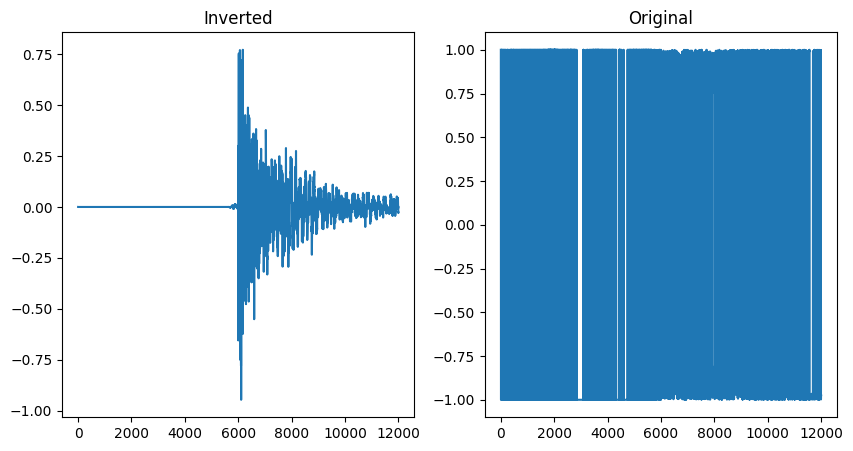

In [14]:
wavs = next(iter(trainDataLoader))
print(wavs.shape, wavs.dtype)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
wav = wavs[0].detach().numpy()
axs[0].plot(wav)
axs[0].set_title('Original')
axs[1].plot(np.where(wav > 0, 1 - wav, -1 - wav))
axs[1].set_title('Inverted')
plt.show()

In [15]:
logger = pl.loggers.TensorBoardLogger('tb_logs', name='audio_autoencoder')

In [16]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="model_weights",
    filename="audioautoencoder-model-{epoch:02d}-{val_loss:.2f}",
)
trainer = pl.Trainer(accelerator='gpu', devices=1,
                     max_epochs=10, logger=logger,
                     callbacks=[checkpoint_callback])

trainer.fit(model, trainDataLoader)

# trainer.save_checkpoint('model_weights/final-bilstm-mode.ckpt')

/home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 129 M 
1 | decoder | Sequential | 129 M 
---------------------------

Epoch 0:   1%|          | 59/5167 [00:04<06:24, 13.29it/s, v_num=15, train_loss_step=0.00231] 

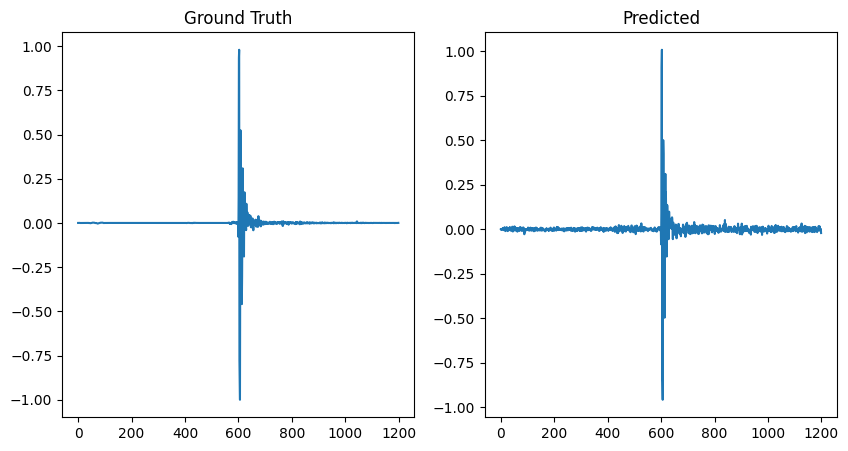

In [16]:
wavs = next(iter(trainDataLoader))
reconstructed = model(wavs)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].plot(wavs[1].detach().numpy())
axs[0].set_title('Ground Truth')
axs[1].plot(reconstructed[1].cpu().detach().numpy())
axs[1].set_title('Predicted')
plt.show()

In [15]:
x = np.array([-1, -0.5, 0, 0.5, 1, -0.2, 0.2])
y = np.where(x >= 0, 1-x, -1-x)
y

array([ 0. , -0.5,  1. ,  0.5,  0. , -0.8,  0.8])